In [193]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scipy.stats as stats
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import random
from scipy.stats import norm
import math
Z = norm.ppf
rng = np.random.default_rng()
sn.set_style('whitegrid')

from scipy.stats import expon
from scipy import special
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from scipy.stats import t
from collections import defaultdict

In [194]:
""" What models are you testing?

set your list of models - these names should map onto column names in your LLM .csv
See provided LLM .csv for example
"""

models = ['Bard', 'GPT-3.5', 'GPT-4']

In [195]:
""" Clean and Set up

Takes a LLM rating .csv and merges with original Graves ratings on phrase
assumes your LLM .csv is formatted similarly to the provided LLM_ratings.csv
creates a binary meaningfulness rating for the continuous human ratings
"""

def CleanForBinaryAnalysis(LLM_csv_name):
    graves = pd.read_csv('/Users/Nick/Downloads/meat-kangaroo-main/graves_2013.csv')
    
    graves['Humans Binary'] = np.where(
        graves['Humans Continuous'] >= 2.5, 'Makes Sense', np.where(
        graves['Humans Continuous'] <= 1.5, 'Nonsense', 'Ambiguous'))
    
    LLM = pd.read_csv(LLM_csv_name)
    
    all_ratings = graves.merge(LLM)
    
    remove_ambiguous = all_ratings[-all_ratings['Humans Binary'].isin(['Ambiguous'])]
    
    remove_ambiguous['Humans Binary ROC'] = np.where(
        remove_ambiguous['Humans Binary'] == 'Nonsense', 0, 1)
    
    return(remove_ambiguous)

In [196]:
cleaned_for_binary = CleanForBinaryAnalysis('/Users/Nick/Downloads/meat-kangaroo-main/LLM_ratings.csv')

C:\Users\Nick\AppData\Local\Temp\ipykernel_7456\3833530484.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_ambiguous['Humans Binary ROC'] = np.where(


In [197]:
""" Confidence Intervals (CIs)

We can conduct the following tests using various CIs based on the human data distributions
That is, using items where 95% or 99% of humans would agree on the meaningfulness of the phrase
This removes phrases that have high variability in responses, meaning these phrases should be 'easier' for LLMs

0 means we are only removing phrases where the mean human response is between 1.5 and 2.5 (e.g., ambiguous items)
STD 1.65 = 95% CI. E.g., items where 5% of people would be expected to answer 'Nonsense' while 95% would answer 'Makes Sense',
or vice versa
STD 2.32 = 99% CI
"""

def SetCI(df, STD):
    sensible = df[(df['Humans Continuous'] >= 2.5) & (df['Humans Continuous'] - (STD * df['SD']) >= 1.5)]
    nonsensible = df[(df['Humans Continuous'] <= 1.5) & (df['Humans Continuous'] + (STD * df['SD']) <= 2.5)]
    return(pd.concat([sensible, nonsensible]))

In [198]:
#NOTE: using the function like this will overwrite your original, cleaned dataframe

cleaned_for_binary = SetCI(cleaned_for_binary, 0)

In [199]:
""" Chi Squared Test

Run Chi Squared Test which compares the expected frequency of responses (human), to the observed (LLMs)

NOTE: a non-significant Chi Squared does not necessarily mean that the LLM is correctly classifying phrases,
it only means that the frequency of responses of the LLM closely matches humans
"""

def ChiSquareLoop(df, models_list):
    fexp = df['Humans Binary'].value_counts()
    
    for model in models_list:
        fobs = cleaned_for_binary[model].value_counts()
        
        chi = stats.chisquare(f_obs=[fobs[0], fobs[1]], f_exp=[fexp[0],fexp[1]])
        
        print('Results for ', model)
        print(fobs)
        print(chi)
        print('################')

In [200]:
ChiSquareLoop(cleaned_for_binary,models)

Results for  Bard
Makes Sense    1169
Nonsense        599
Name: Bard, dtype: int64
Power_divergenceResult(statistic=84.33613049571238, pvalue=4.174168871181677e-20)
################
Results for  GPT-3.5
Makes Sense    1462
Nonsense        306
Name: GPT-3.5, dtype: int64
Power_divergenceResult(statistic=538.1392766887463, pvalue=4.7888388287186386e-119)
################
Results for  GPT-4
Nonsense       1045
Makes Sense     723
Name: GPT-4, dtype: int64
Power_divergenceResult(statistic=10.57862053526948, pvalue=0.0011440299410133523)
################


In [201]:
""" Signal Detection Theory 

Function that calculates various SDT metrics we will use later
"""

def SDT(hits, misses, fas, crs):
    """ returns a dict with d-prime measures given hits, misses, false alarms, and correct rejections"""
    # Floors an ceilings are replaced by half hits and half FA's
    half_hit = 0.5 / (hits + misses)
    half_fa = 0.5 / (fas + crs)
     # Calculate hit_rate and avoid d' infinity
    hit_rate = hits / (hits + misses)
    if hit_rate == 1: 
        hit_rate = 1 - half_hit
    if hit_rate == 0: 
        hit_rate = half_hit
 
    # Calculate false alarm rate and avoid d' infinity
    fa_rate = fas / (fas + crs)
    if fa_rate == 1: 
        fa_rate = 1 - half_fa
    if fa_rate == 0: 
        fa_rate = half_fa
        
    #transform beta to base 10 log of beta
    beta = math.exp((Z(fa_rate)**2 - Z(hit_rate)**2) / 2)
    beta = math.log10(beta)
 
    # Return d', beta, c and Ad'
    out = {}
    out['d'] = Z(hit_rate) - Z(fa_rate)
    out['beta'] = beta
    out['c'] = -(Z(hit_rate) + Z(fa_rate)) / 2
    out['Ad'] = norm.cdf(out['d'] / math.sqrt(2))
    
    return(out)

In [202]:
""" SDT, Part 2

Calculate SDT metrics on your models, output counts, graphs, and metrics (e.g., D prime)
"""

def RunSDT(df, models_list):
    for model in models_list:
        answer_type = [
            (df[model] == 'Makes Sense') & (df['Humans Binary'] == 'Nonsense'),
            (df[model] == 'Nonsense') & (df['Humans Binary'] == 'Makes Sense'),
            (df[model] == 'Makes Sense') & (df['Humans Binary'] == 'Makes Sense'),
            (df[model] == 'Nonsense') & (df['Humans Binary'] == 'Nonsense')
        ]
        
        answer_names = ['False Alarm', 'Miss', 'Hit', 'Correct Rejection']

        new_col = model + ' Answer Type'
        
        df[new_col] = np.select(answer_type, answer_names)
        
        fas, misses, hits, crs = [df[new_col].value_counts()[answer_names[i]] for i in range(len(answer_names))]
        
        SDT_result = SDT(hits, misses, fas, crs)
        
        print(model)
        print('Hits: ', hits)
        print('Misses: ', misses)
        print('False Alarms: ', fas)
        print('Correct Rejections: ', crs)
        print('SDT Results')
        print(SDT_result)

        sn.countplot(data=df, x=df[new_col], order=['Hit', 'Miss', 'False Alarm', 'Correct Rejection'])
        plt.show()
        
        print('####################')

Bard
Hits:  608
Misses:  183
False Alarms:  561
Correct Rejections:  416
SDT Results
{'d': 0.5473046972769824, 'beta': -0.1095155835824869, 'c': -0.4607469138529229, 'Ad': 0.6506229557211693}


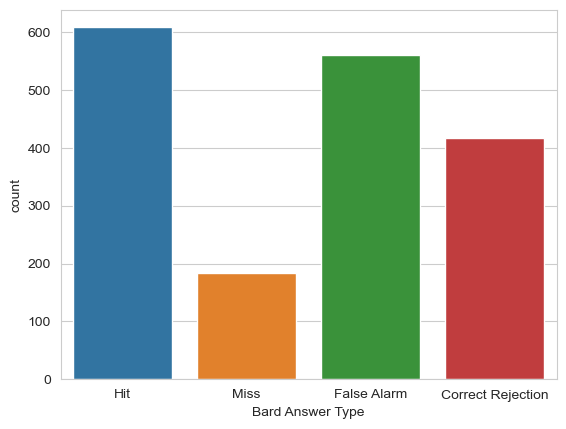

####################
GPT-3.5
Hits:  732
Misses:  59
False Alarms:  730
Correct Rejections:  247
SDT Results
{'d': 0.7767817242171585, 'beta': -0.3555856393312216, 'c': -1.054049248174552, 'Ad': 0.7085890990319968}


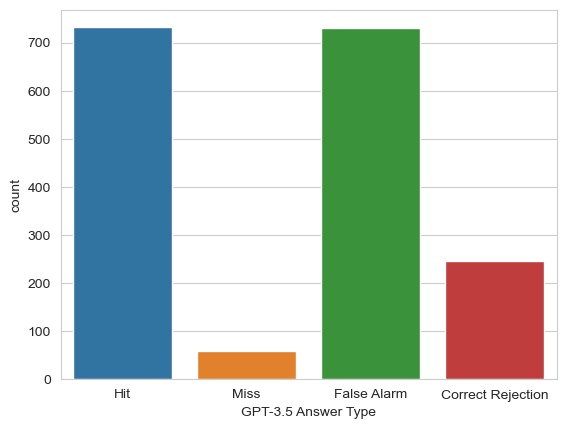

####################
GPT-4
Hits:  594
Misses:  197
False Alarms:  129
Correct Rejections:  848
SDT Results
{'d': 1.7942909038840023, 'beta': 0.17117715989095944, 'c': 0.21966893761362039, 'Ad': 0.8977358176805736}


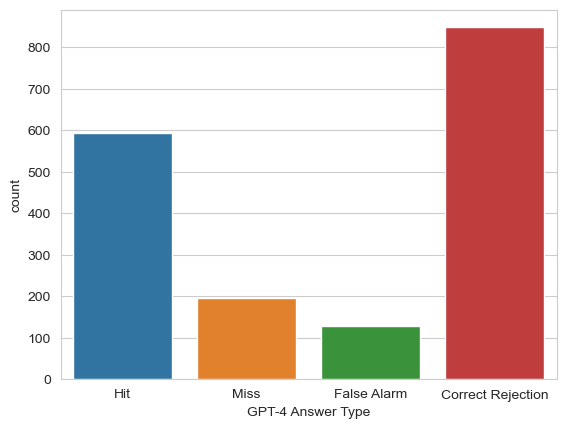

####################


In [203]:
RunSDT(cleaned_for_binary,models)

In [204]:
""" Reciever Operating Characteristic

Make ROC curve for models, plot them
Output area under the curve

"""

def ROCPlots(df, models_list):

    labels_for_ROC = [0,1]

    human_for_ROC = [
        (df['Humans Binary'] == 'Nonsense'),
        (df['Humans Binary'] == 'Makes Sense')
    ]

    truth = np.select(human_for_ROC, labels_for_ROC)
    random = np.random.randint(0,2,size=len(df))

    rand_fpr, rand_tpr, thresholds = roc_curve(truth, random, pos_label=1)

    pyplot.plot(rand_fpr, rand_tpr, marker='.', label='Random')
    
    for model in models_list:
    #    predict = model + ' Predicted'

        LLM_for_ROC = [
            (df[model] == 'Nonsense'),
            (df[model] == 'Makes Sense')
        ]

        predicted = np.select(LLM_for_ROC, labels_for_ROC)

        fpr, tpr, thresholds = roc_curve(truth, predicted, pos_label=1)

        pyplot.plot(fpr, tpr, marker='.', label = model)
        
        auc = roc_auc_score(truth,predicted)
        
        print(model + ' AUC: ', auc)
    
    pyplot.legend()
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.show()

Bard AUC:  0.5972202632740128
GPT-3.5 AUC:  0.5891128056552283
GPT-4 AUC:  0.8094556596925234


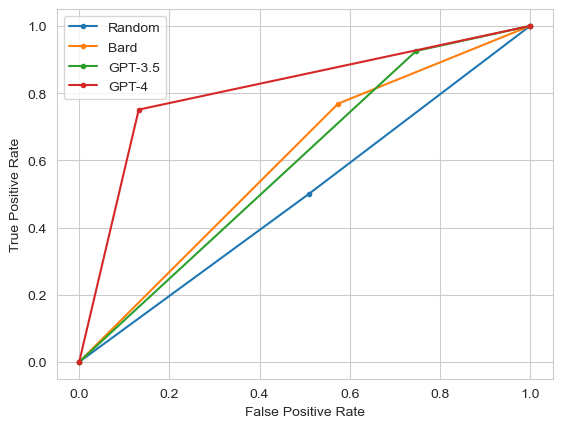

In [205]:
ROCPlots(cleaned_for_binary,models)

In [206]:
""" Implementation of Crawford and Howell (1998; The Clinical Neuropsychologist) test to compare an individual to a sample.
    
    This function will be called later
    
    Args:
      case : score of the individual
      controls : scores of from a sample group

    Return:
      the one-tail probability associated to the score 'case' compared to the scores in the list 'controls'
"""

def CrawfordTest(case, controls):

    if np.std(controls,ddof=1) == 0:
        tobs = case - np.mean(controls)
    else:
        tobs = (case - np.mean(controls)) / np.std(controls, ddof=1)
        
    if tobs >= 0:
        return 1 - t.cdf(tobs, len(controls) - 1)
    else:
        return t.cdf(tobs, len(controls) - 1)

In [207]:
""" Generate Distributions

This function uses the original means and standard deviations of the Graves 2013 data to simulate
an N-sized response distribution for each phrase

That is, if N human participants rated these phrases, what type of distribution could we expect?

We will use these distributions later to test 'cases' (LLMs) against the 'controls' (human response distribution)

This will identify 'outlier' cases that are highly unlikely to belong to the human distribution, i.e.,
phrases where the LLMs fail to rate meaningfulness in a way that resembles human conceptions of meaningfulness

Simulated Distribution = generated phrase-wise human response dist

Permuted Distribution = randomly selected 0-4 integers, based on cumulative probability of 0, 1, 2, 3, 4 mean responses
of entire dataset

"""

def GenerateDistributions(df, N=10000):
    min_value = 0
    max_value = 4
    df['Simulated Distribution'] = ''
    df['Permuted Distribution'] = ''
    
    for index, row in df.iterrows():
        mean = row['Humans Continuous']
        std = row['SD']
        
        if std == 0:
            min_in_standard_domain = (min_value - mean)
            max_in_standard_domain = (max_value - mean)
        else:
            min_in_standard_domain = (min_value - mean) / std
            max_in_standard_domain = (max_value - mean) / std
    
        min_in_erf_domain = special.erf(min_in_standard_domain)
        max_in_erf_domain = special.erf(max_in_standard_domain)
    
        random_uniform_data = np.random.uniform(min_in_erf_domain, max_in_erf_domain, N)
        random_gaussianized_data = (special.erfinv(random_uniform_data) * std) + mean
    
        random_gaussianized_data = np.around(random_gaussianized_data,0)
    
        df.at[index, 'Simulated Distribution'] = random_gaussianized_data
        df.at[index, 'Permuted Distribution'] = np.random.choice(5, N, p=[.07,.38,.19,.16,.20])
    
    return(df)

In [208]:
cleaned_for_continuous = GenerateDistributions(cleaned_for_binary)

In [209]:
""" Test: Cases vs. Controls

Here, we implement the Crawford and Howell t-test, testing cases (LLM responses) against controls (human distribution)

Outputs a few graphs showing the models' responses compared to human distribution for N phrases

Returns dictionary format {model: [number of outlier responses at p_value]}

This is the number of times that the LLM provided a response outside of the range defined by p_value (default 0.05),
e.g., responses that have a less than 5% chance of coming from the human distribution

We can later test these 'outlier counts' against a distribution of human outlier responses - i.e., in 1000 simulated human
participants, whose responses are based on the underlying response distributions for each phrase, 
how many outlier responses should we expect?

We can also test these outlier counts against permuted data

"""

def CompareToSimulatedDist(df, models_list, N=10, p_value=0.05):
    outlier_counts = {}
    
    for model in models_list:
        outlier_counts[model] = 0
    
    for index, row in df.iterrows():
        for model in models_list:
            col_name = model + ' Continuous'

            T = CrawfordTest(row[col_name], row['Simulated Distribution'])
            
            if T < p_value:
                outlier_counts[model] += 1
            else:
                pass

            if index < N:
                fig, axes = plt.subplots(1, 1, figsize=(4,2))
                plt.axvline(x=row[col_name], color='r')
                axes.hist(row['Simulated Distribution'], 20, range=(0,4))
                axes.set_title((row[0] + model))
            
                plt.show()
            else:
                pass
    
    print(outlier_counts)
    return(outlier_counts)

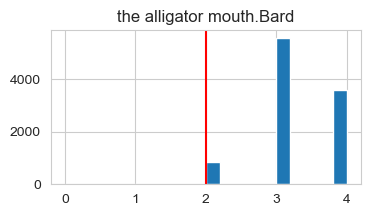

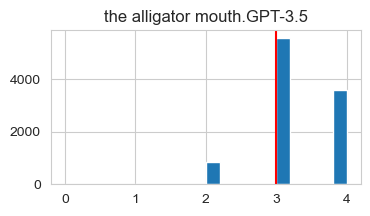

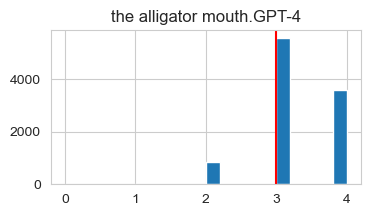

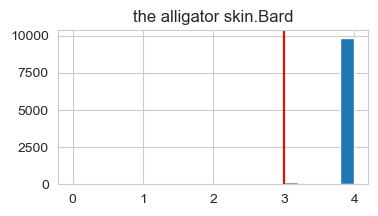

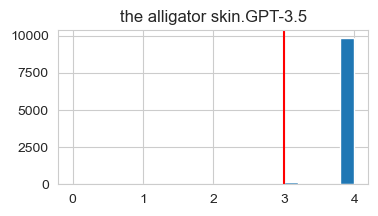

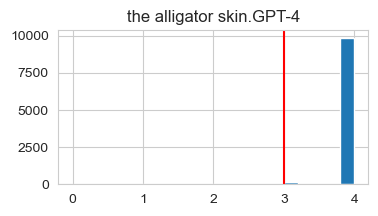

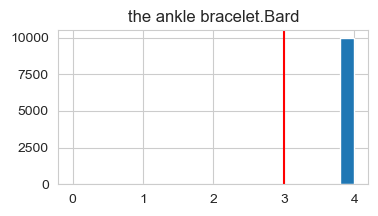

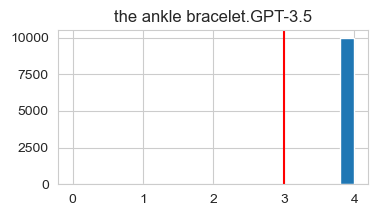

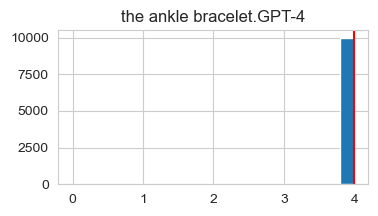

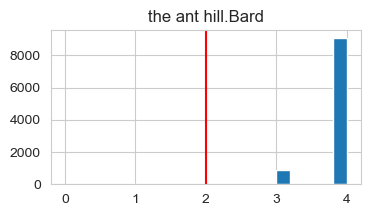

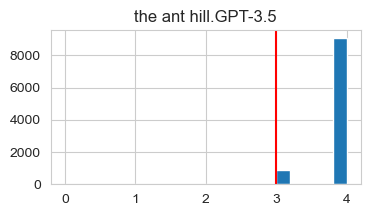

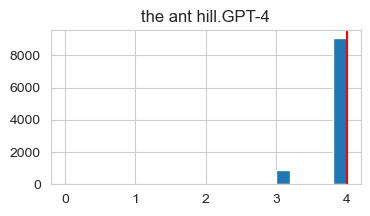

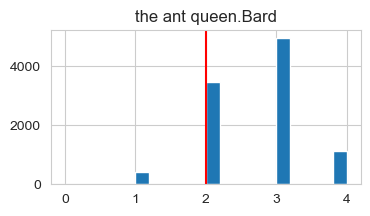

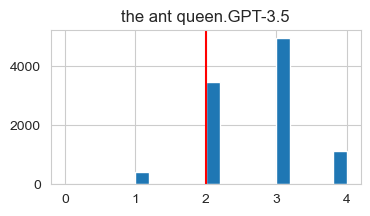

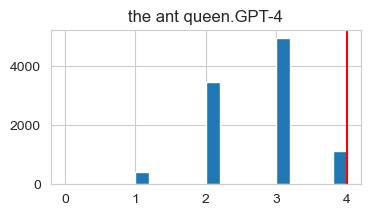

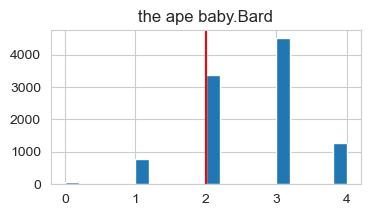

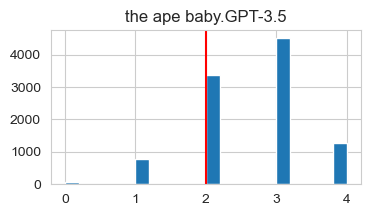

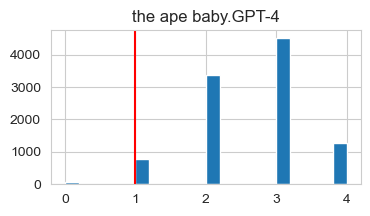

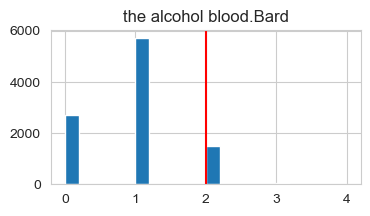

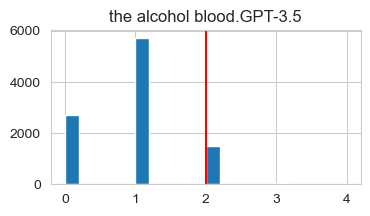

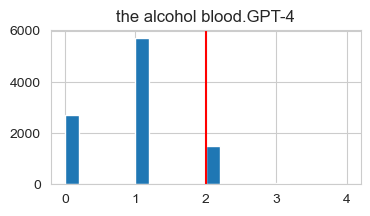

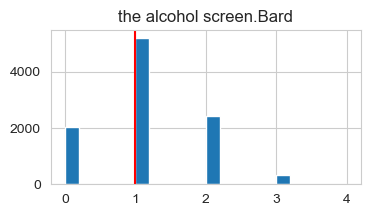

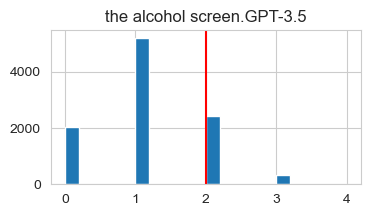

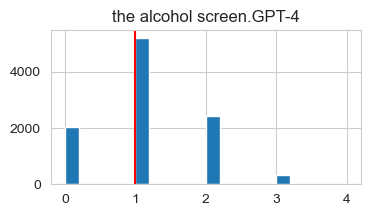

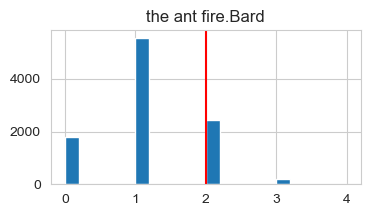

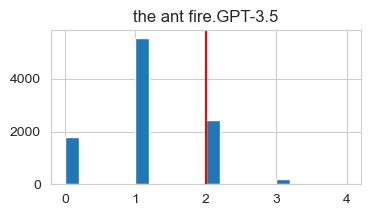

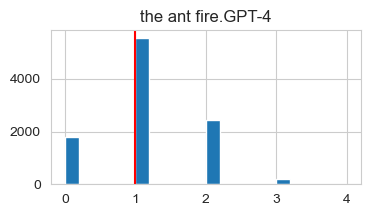

{'Bard': 752, 'GPT-3.5': 871, 'GPT-4': 411}


In [210]:
model_counts = CompareToSimulatedDist(cleaned_for_continuous, models)

In [211]:
def ControlTests(df,N=1000,p_value=0.05):
    sim_outliers = {}
    distributions = ['Simulated Distribution', 'Permuted Distribution']

    for dist in distributions:
        sim_outliers[dist] = []

        for i in range(0,N):
            outlier_count = 0

            for index, row in df.iterrows():
                case = np.random.choice(row[dist])

                T = CrawfordTest(case, row['Simulated Distribution'])

                if T < p_value:
                    outlier_count += 1
                else:
                    pass

            sim_outliers[dist].append(outlier_count) 

    return(sim_outliers)       

In [212]:
control_counts = ControlTests(cleaned_for_continuous)

In [225]:
def PlotOutlierCounts(model_counts,control_counts):
    for key in model_counts:
        fig, axes = plt.subplots(1,1, figsize=(6,3))
        axes.hist(control_counts['Simulated Distribution'], color='blue')
        axes.hist(control_counts['Permuted Distribution'], color='orange')
        plt.axvline(x=model_counts[key], color='r')
        
        for dist in ['Simulated Distribution', 'Permuted Distribution']:
            T = CrawfordTest(model_counts[key], control_counts[dist])
            
            print('T-test p_value: ' + key + ' vs. ' + dist, T)
        
        print(key + ' vs. Simulated and Permuted')
        
        plt.show()
        
#         key + ' vs. ' + dist + ' t-test results = ' + 

T-test p_value: Bard vs. Simulated Distribution 0.0
T-test p_value: Bard vs. Permuted Distribution 1.4489106361081276e-12
Bard vs. Simulated and Permuted


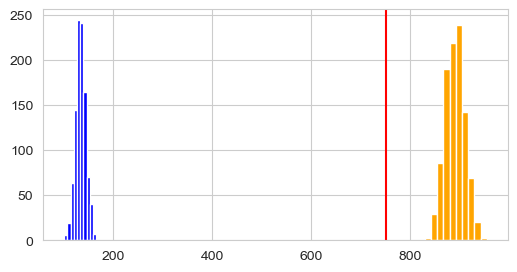

T-test p_value: GPT-3.5 vs. Simulated Distribution 0.0
T-test p_value: GPT-3.5 vs. Permuted Distribution 0.15171590421340583
GPT-3.5 vs. Simulated and Permuted


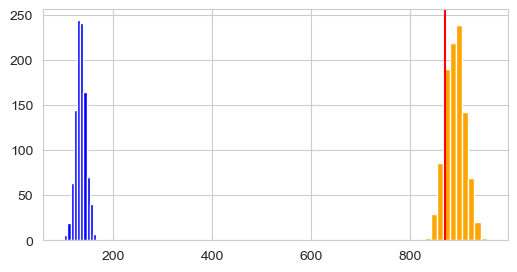

T-test p_value: GPT-4 vs. Simulated Distribution 0.0
T-test p_value: GPT-4 vs. Permuted Distribution 1.0794677504180012e-103
GPT-4 vs. Simulated and Permuted


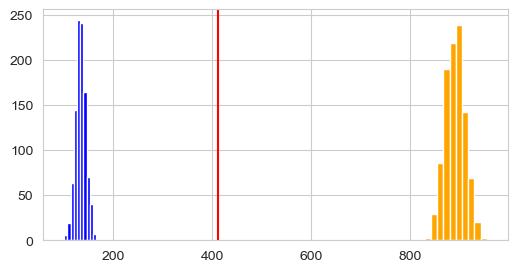

In [226]:
PlotOutlierCounts(model_counts,control_counts)